Try out our kNN bootstrap method on the degree heterogeneous international trade data. 

Will bootstrap the 2020 data, then can compare it to 2021 for the whole, is this the same?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from tqdm import tqdm
from math import comb
import random
import scipy

In [2]:
folder = "/home/uj21900/Documents/CommonCrawlData/InternationalTradeData/"

In [3]:
# Read in the export data from 2016 to 2021
M_2016_2021_list = []
for t in range(2016,2022):
    filename = folder + 'M_export_' + str(t) + '.csv'
    df = pd.read_csv(filename)
    M = np.array(df)
    M_2016_2021_list.append(M)

In [4]:
# read in the export indices names
total = pd.read_csv(folder+'exportMatricesIndices.csv', header=None)

total = list(total[0])

In [5]:
M_2016_2021_list
n = M_2016_2021_list[0].shape[0]
T = len(M_2016_2021_list)
print(n,T)

144 6


In [6]:
# put A_list into a 3D array
As = np.zeros((T,n,n))
for t in range(T):
    As[t,:,:] = M_2016_2021_list[t]

In [7]:
# read in inflation rate data, at a world level
# https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG
inflationrates = pd.read_csv(folder+'worldbank_inflationRateData.csv')

worldIR = inflationrates[inflationrates['Country Name']=='World']

In [8]:
worldIR = worldIR.iloc[:, -(T+1):]
# remove the last column as it's for 2022
worldIR = worldIR.iloc[:, :-1]
worldIR = worldIR.reset_index(drop=True)
worldIR

,2016,2017,2018,2019,2020,2021
0,1.550016,2.19201,2.438737,2.206073,1.928955,3.475403


In [9]:
# put the values in a list
worldIRlist = list(worldIR.iloc[0,:])

# want it to be the proportion, i.e, 3% = 1.03
worldIRlist_prop = [x/100 + 1 for x in worldIRlist]

In [10]:
IRadj_As = np.zeros((T,n,n))

from functools import reduce

for t in range(T):
    mat = As[t]
    cumulative_inflation = worldIRlist_prop[(t+1):T]
    # multiply all items in a list
    if len(cumulative_inflation) > 0:
        cumulative_inflation = reduce(lambda x, y: x*y, cumulative_inflation)
    else:
        cumulative_inflation = 1
    mat = mat*cumulative_inflation
    IRadj_As[t] = mat

In [11]:
# LOOK AT 2020
A_2020 = IRadj_As[4]
d=2
ya = UASE([A_2020], d)
# plot_embedding(ya, n, 1, np.ones(n))

In [12]:
yadf = pd.DataFrame(ya)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 
# give each node a number
yadf['node_number'] = list(range(n))
yadf['country'] = total

In [13]:
fig = px.scatter(yadf, x="Dimension_1", y="Dimension_2",
                hover_data=["country", "node_number"],
                color_continuous_scale = 'Bluered', title=f"The A matrix for 2020 embedded, with UASE d={d}")

fig.show()

#### threshold of $0 to make binary

In [14]:
# make some unweighted networks
binary_As = []
for A in IRadj_As:
    A_bin = A.copy()
    A_bin[A_bin > 0] = 1
    binary_As.append(A_bin)

In [15]:
european_countries = [
    "Albania", "Andorra", "Armenia", "Australia", "Austria", "Azerbaijan", "Belarus", 
    "Belgium", "Bosnia Herzegovina", "Bulgaria", "Canada", "Croatia", "Czechia", 
    "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", 
    "Iceland", "Ireland", "Italy", "Latvia", "Lichtenstein", "Lithuania", "Luxembourg", 
    "Malta", "Monaco", "Montenegro", "Netherlands", "New Zealand", "North Macedonia", 
    "Norway", "Poland", "Portugal", "Rep. of Moldova", "Romania", "Russian Federation", 
    "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", 
    "T�rkiye", "Ukraine", "United Kingdom", 
]

#https://www.un.org/dgacm/en/content/regional-groups
# israel, turkiye and US had stars, just kept turkiye

In [16]:
len(european_countries)

50

In [17]:
# which european countries are not in the total list
for c in european_countries:
    if c not in total:
        print(c)

# these are all really tiny so must have either not been, or were excluded from the data

Lichtenstein
Monaco
San Marino


In [18]:
eu_countries_in_data = [c for c in european_countries if c in total]
len(eu_countries_in_data)

47

In [19]:
# find indexes of total where the value is in eu_countries_in_data
eu_indexes = [total.index(c) for c in eu_countries_in_data]

In [20]:
binary_A_eu = []
for A in binary_As:
    A_eu = A[eu_indexes][:,eu_indexes]
    binary_A_eu.append(A_eu)

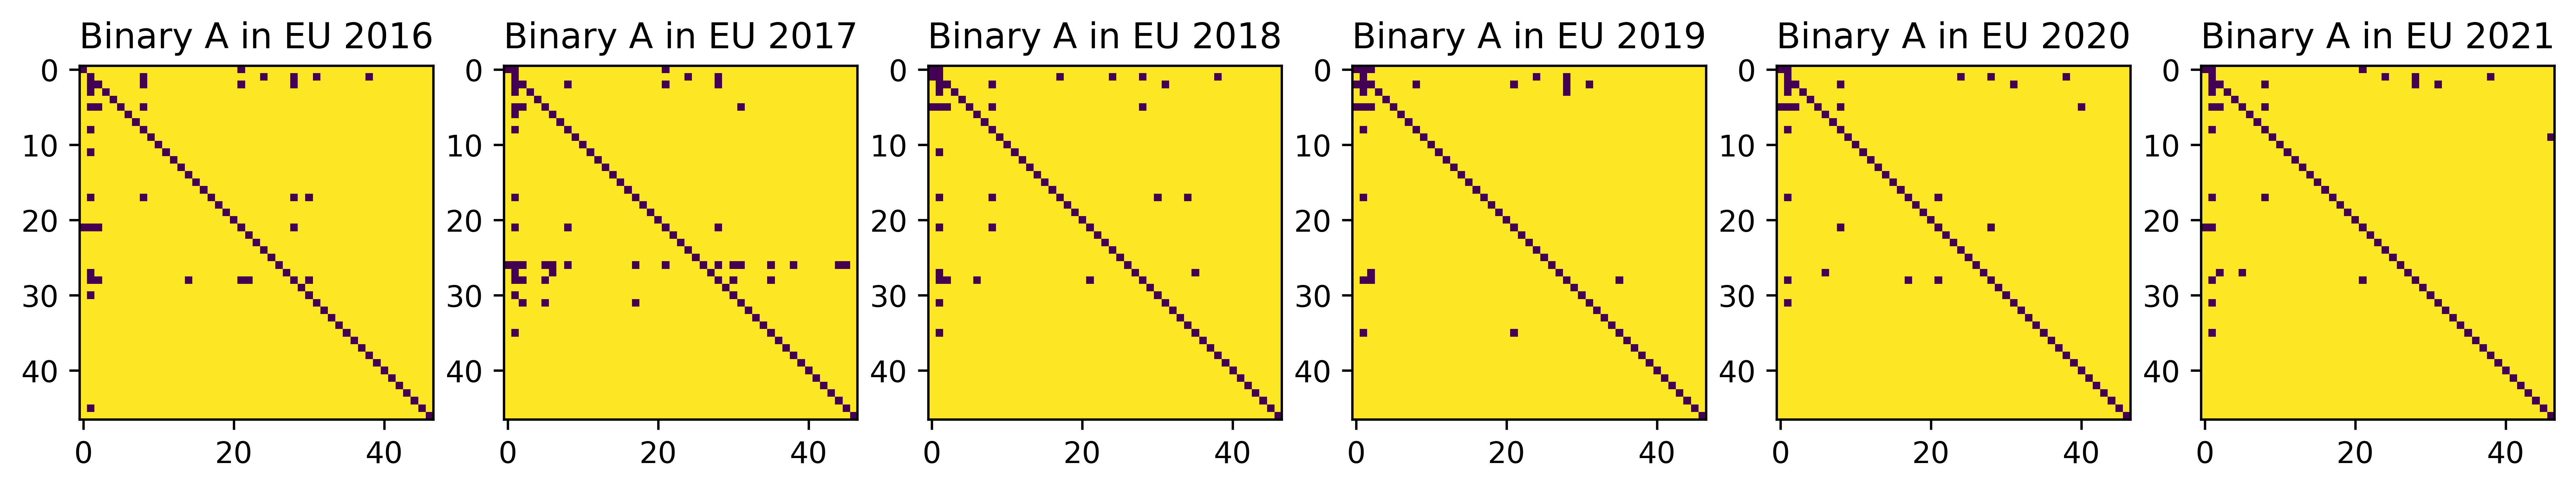

In [21]:
# plot in one figure the heatmaps for the binary networks
fig, axs = plt.subplots(1,6, figsize=(15, 10),dpi=600)
for i, ax in enumerate(axs.flat):
    ax.imshow(binary_A_eu[i])
    ax.set_title(f"Binary A in EU {2016+i}")

### non-zero threshold to make binary

Decide where to set the threshold

In [22]:
# DEFINE THRESHOLD
threshold = 1_000_000 # np.median(all_As_flat)

# make some unweighted networks
binary_As_thres = []

for A in IRadj_As:    
    A_bin = A.copy()
    A_bin[A_bin <= threshold] = 0
    A_bin[A_bin > threshold] = 1
    binary_As_thres.append(A_bin)

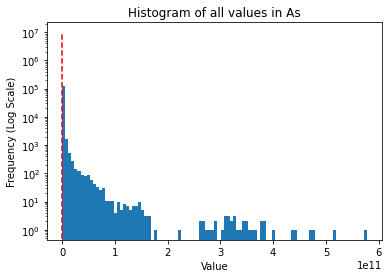

In [23]:
# plot a histogram of all the values in As
all_As = np.concatenate(IRadj_As)
all_As_flat = all_As.flatten()
plt.hist(all_As_flat, bins=100)
plt.yscale('log')
# plt.xscale('log')
plt.title("Histogram of all values in As")
plt.xlabel("Value")
plt.ylabel("Frequency (Log Scale)")
plt.vlines(threshold, 0, 1e7, colors='r', linestyles='dashed')
plt.show()

In [24]:
[np.median(all_As_flat) , np.mean(all_As_flat)]

[1623366.676677559, 870723792.47465]

In [25]:
# find the percentage of values above the threshold
np.sum(all_As_flat > threshold)/len(all_As_flat) * 100

52.95621141975309

just looking at europe

In [26]:
binary_A_eu_thres = []
for A in binary_As_thres:
    A_eu = A[eu_indexes][:,eu_indexes]
    binary_A_eu_thres.append(A_eu)

/tmp/ipykernel_52249/837478707.py:10: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



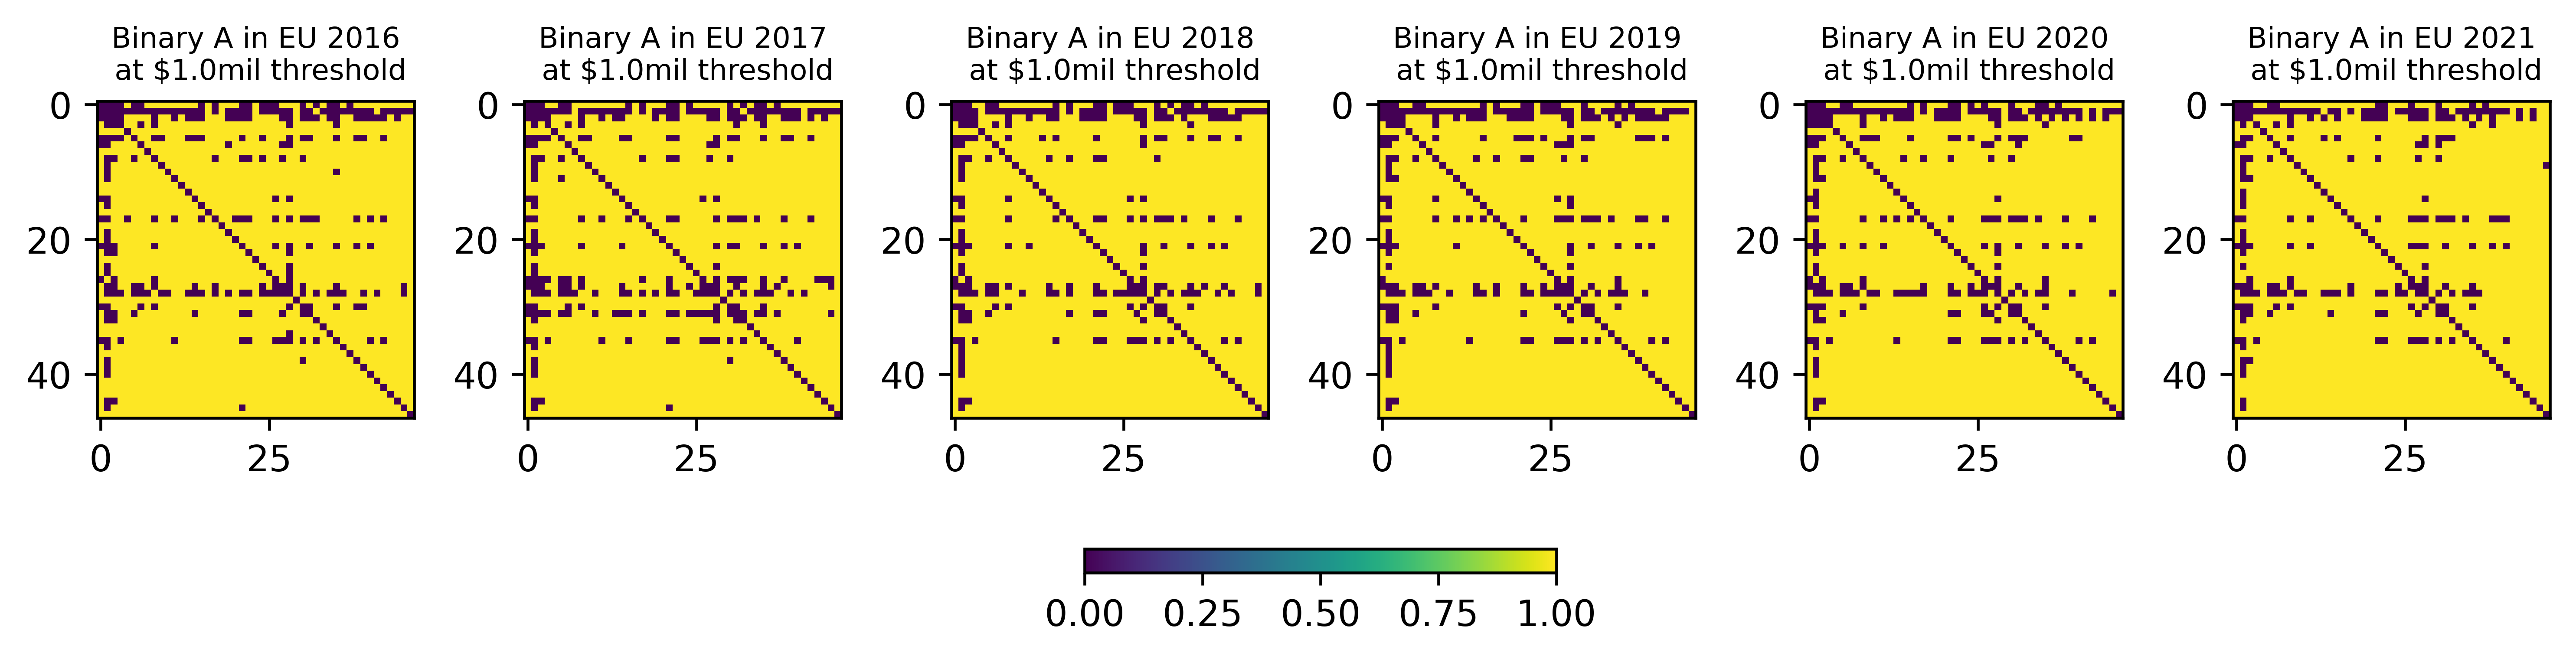

In [27]:
fig, axs = plt.subplots(1, 6, figsize=(10, 6), dpi=600)
heatmaps = []
for i, ax in enumerate(axs.flat):
    heatmap = ax.imshow(binary_A_eu_thres[i])
    ax.set_title(f"Binary A in EU {2016+i}\n at ${threshold/1_000_000}mil threshold", fontsize=8)
    heatmaps.append(heatmap)
# Add one colorbar for all heatmaps
cbar = fig.colorbar(heatmaps[0], ax=axs, orientation='horizontal', fraction=0.02, pad=-0.1)

plt.tight_layout(rect=[0, 0.1, 1, 0.8])  # Adjust layout to make room for the colorbar
plt.show()

In [28]:
def dim_select(A, plot=True, plotrange=50):
    ## IAN - NEEDS UPDATING FOR DILATED MATRIX ##
    """ 
    Select the number of dimensions for A.
    Finding a changepoint using the likelihood profile (Zhu, Ghodsi; 2006). I've just lifted this from Ian so it might need updating.

    Parameters
    ----------  
    As : numpy.array
        The array of matrices.
    plot : bool
        Whether to plot the singular values and the likelihood profile.
    plotrange : int
        The range of dimensions to be plotted.

    Returns
    -------
    lq_best : int
        The number of dimensions selected.
    """
    if scipy.sparse.issparse(A):
        A = A.todense()

    UA, SA, VAt = np.linalg.svd(A)

    # Compute likelihood profile
    n = len(SA)
    lq = np.zeros(n)
    lq[0] = 'nan'
    for q in range(1, n):
        theta_0 = np.mean(SA[:q])
        theta_1 = np.mean(SA[q:])
        sigma = np.sqrt(
            ((q-1)*np.var(SA[:q]) + (n-q-1)*np.var(SA[q:])) / (n-2))
        lq_0 = np.sum(np.log(stats.norm.pdf(SA[:q], theta_0, sigma)))
        lq_1 = np.sum(np.log(stats.norm.pdf(SA[q:], theta_1, sigma)))
        lq[q] = lq_0 + lq_1
    lq_best = np.nanargmax(lq)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12.0, 4.0))
        plt.subplots_adjust(hspace=0.3)

        axs[0].plot(range(plotrange), SA[:plotrange], '.-')
        axs[0].set_title('Singular values')
        axs[0].set_xlabel('Number of dimensions')
        axs[0].axvline(x=lq_best, ls='--', c='k')

        axs[1].plot(range(plotrange), lq[:plotrange], '.-')
        axs[1].set_title('Log likelihood')
        axs[1].set_xlabel('Number of dimensions')
        axs[1].axvline(x=lq_best, ls='--', c='k')

    return lq_best

In [29]:
# dim_select(np.concatenate(binary_A_eu_thres), plotrange = 47)

100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


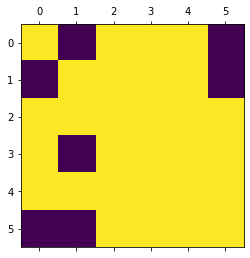

In [30]:
# EMBED
d = 4
ya = UASE(binary_A_eu_thres, d, flat=False)

p_val_matrix = np.ones((T, T))
num_p_val_comps = 0
num_p_vals_to_compute = int(T * (T - 1) / 2)
# nodes_compared_mat = np.zeros((T, T))
for i in tqdm(range(p_val_matrix.shape[0])):
    for j in range(p_val_matrix.shape[1]):
        num_p_val_comps += 1

        ya_temp = np.concatenate((ya[i], ya[j]))
        p_val = test_temporal_displacement_two_times(ya_temp, n=ya[i].shape[0])

        p_val_matrix[i, j] = p_val

p_val_mat = plt.matshow(p_val_matrix > 0.05 / comb(T, 2))

# YELLOW = 1, p-val over bonferonni corrected threshold => not signifcantly different (= exchangeableish)
# PURPLE = 0, not the same

100%|██████████| 6/6 [00:00<00:00, 10.89it/s]


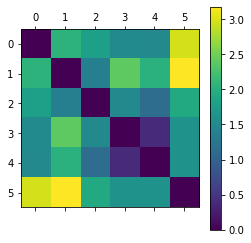

In [31]:
# EMBED
ya = UASE(binary_A_eu_thres, d, flat=False)

p_val_matrix = np.ones((T, T))
num_p_val_comps = 0
num_p_vals_to_compute = int(T * (T - 1) / 2)
# nodes_compared_mat = np.zeros((T, T))
for i in tqdm(range(p_val_matrix.shape[0])):
    for j in range(p_val_matrix.shape[1]):
        num_p_val_comps += 1

        p_val = vector_displacement_test(ya[i], ya[j]) # #this is not a test, this is a distance, which one could call a "test statistic"
        p_val_matrix[i, j] = p_val

p_val_mat = plt.matshow(p_val_matrix)
plt.colorbar(p_val_mat)

# PURPLE = 0, low disimilarity
# YELLOW = high disimilarity
# this is just a distance, not a test, so no significance

look at all countries in the data

/tmp/ipykernel_52249/3206039747.py:10: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



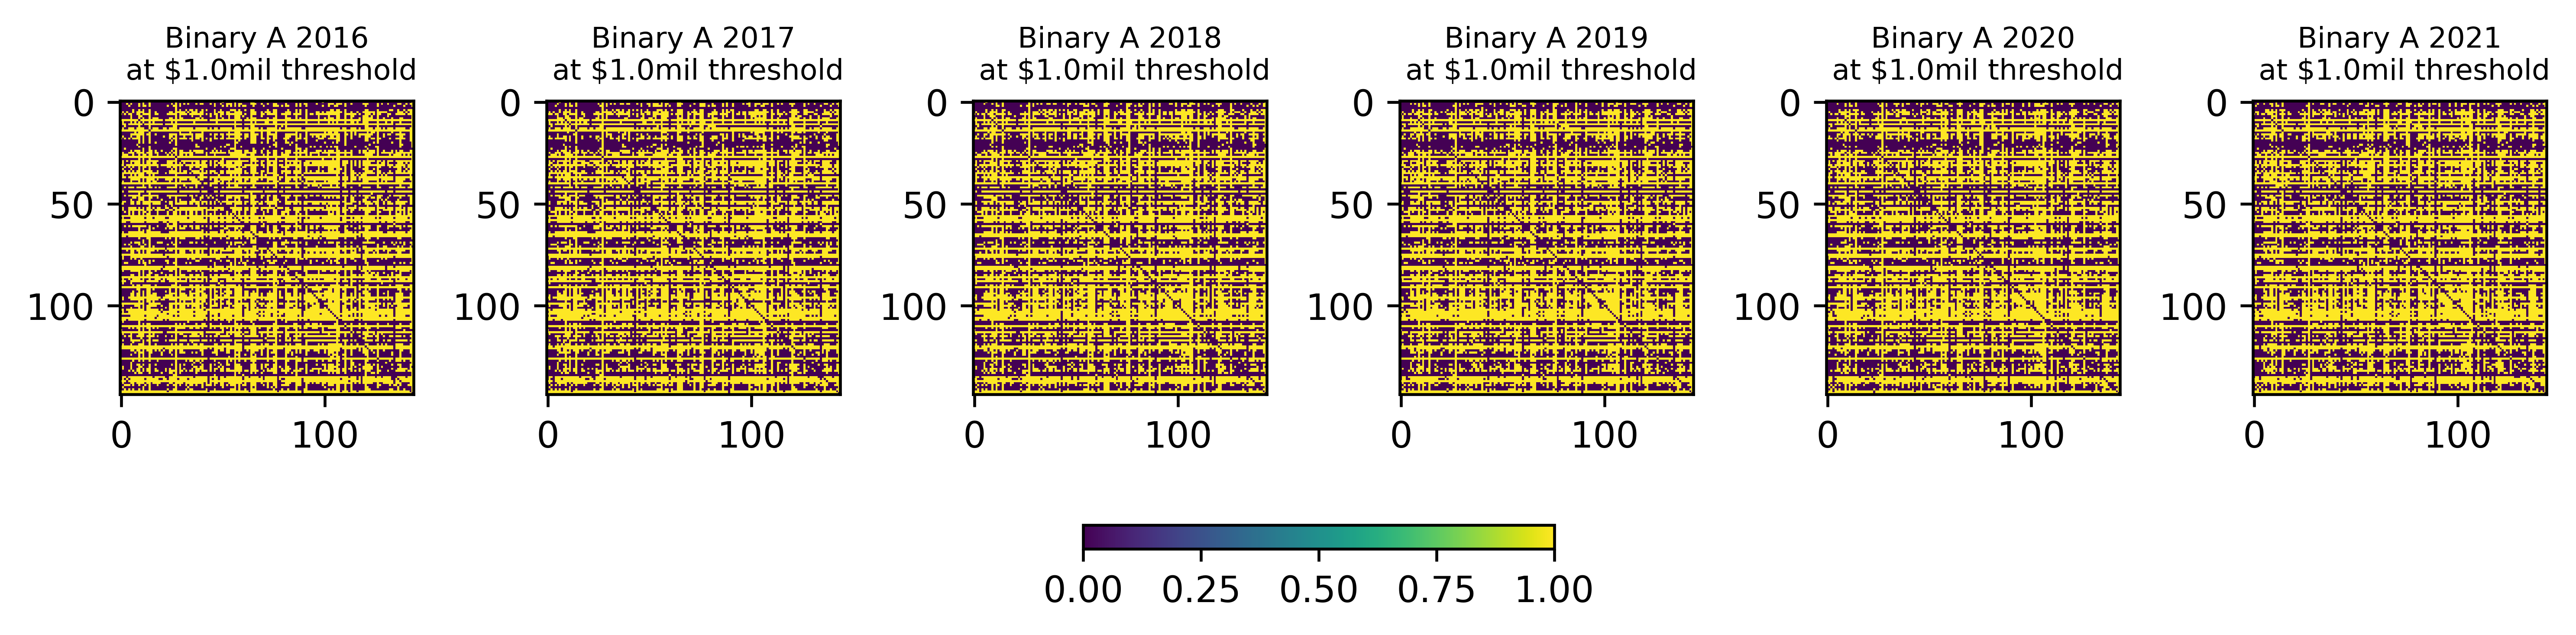

In [32]:
fig, axs = plt.subplots(1, 6, figsize=(10,6), dpi=600)
heatmaps = []
for i, ax in enumerate(axs.flat):
    heatmap = ax.imshow(binary_As_thres[i])
    ax.set_title(f"Binary A {2016+i}\n at ${threshold/1_000_000}mil threshold", fontsize=8)
    heatmaps.append(heatmap)
# Add one colorbar for all heatmaps
cbar = fig.colorbar(heatmaps[0], ax=axs, orientation='horizontal', fraction=0.02, pad=-0.1)

plt.tight_layout(rect=[0, 0.1, 1, 0.8])  # Adjust layout to make room for the colorbar
plt.show()

100%|██████████| 6/6 [00:00<00:00, 32.62it/s]


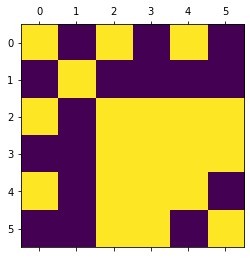

In [33]:
# EMBED
d = 4
ya = UASE(binary_As_thres, d, flat=False)

p_val_matrix = np.ones((T, T))
num_p_val_comps = 0
num_p_vals_to_compute = int(T * (T - 1) / 2)
# nodes_compared_mat = np.zeros((T, T))
for i in tqdm(range(p_val_matrix.shape[0])):
    for j in range(p_val_matrix.shape[1]):
        num_p_val_comps += 1

        ya_temp = np.concatenate((ya[i], ya[j]))
        p_val = test_temporal_displacement_two_times(ya_temp, n=ya[i].shape[0])

        p_val_matrix[i, j] = p_val

p_val_mat = plt.matshow(p_val_matrix > 0.05 / comb(T, 2))

100%|██████████| 6/6 [00:00<00:00, 43240.25it/s]


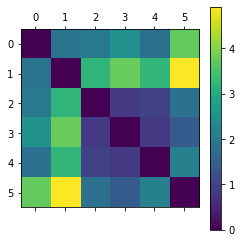

In [34]:
# EMBED
ya = UASE(binary_As_thres, d, flat=False)

p_val_matrix = np.ones((T, T))
num_p_val_comps = 0
num_p_vals_to_compute = int(T * (T - 1) / 2)
# nodes_compared_mat = np.zeros((T, T))
for i in tqdm(range(p_val_matrix.shape[0])):
    for j in range(p_val_matrix.shape[1]):
        num_p_val_comps += 1

        p_val = vector_displacement_test(ya[i], ya[j])

        p_val_matrix[i, j] = p_val

p_val_mat = plt.matshow(p_val_matrix)
plt.colorbar(p_val_mat)

### Try and do some stuff with the european countries in d=4 dimensions, seeing if 2021 is different

<!-- the bonferoni corrected distance matrix implies that 2016-2020 are all pretty similar to each other. 2021 is most different to 2016/2017. If we treat 2016-2020 as exchangeable, i.e. some empirical estimate from this, we can bootstrap 2020 only and see if we get similar matrices back.  -->

bootstrap 2016, compare the bootstraps with 2017-2021, are results similar to the comparison of the true 2016 with 2017-2021?

In [35]:
# for 2016 matrix, create a bootstrap and perform a test with Q permutations
# do this 100 times
random.seed(1)
p_vals = []
A_boots_list = []

for m in range(1000):
    p_val, A_boots = create_single_kNN_bootstrap(binary_A_eu_thres[0], d=d, Q=1000, n_neighbors=3)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# is really sensitive to the number of neighbours
# the diagonal is always 0 for the truth, but not for the bootstraps. We could enforce this if we wanted, but this is a limimtation that comes from our bootstraps being probabilistic.

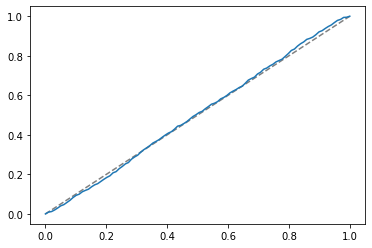

0.041

In [36]:
plot_power(p_vals, plot=True)

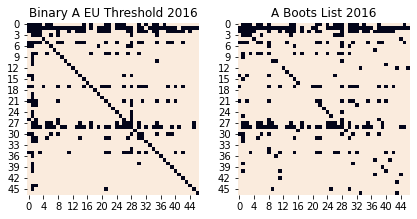

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

sns.heatmap(binary_A_eu_thres[0], ax=axs[0], square=True, cbar=False)
axs[0].set_title('Binary A EU Threshold 2016')

sns.heatmap(A_boots_list[0], ax=axs[1], square=True, cbar=False)
axs[1].set_title('A Boots List 2016')

plt.tight_layout()
plt.show()

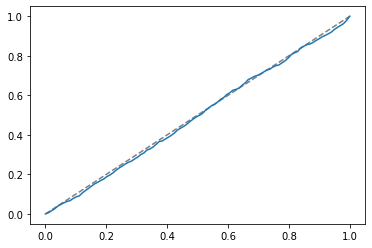

0.048

In [38]:
# for 2016 matrix, create a bootstrap and perform a test with Q permutations
# do this 1000 times
'''force the diagonal to be 0'''
random.seed(1)
p_vals = []
A_boots_list = []

for m in range(1000):
    p_val, A_boots = create_single_kNN_bootstrap_force0diag(binary_A_eu_thres[0], d=d, Q=1000, n_neighbors=4) # NEW FUNCTION
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

plot_power(p_vals, plot=True)

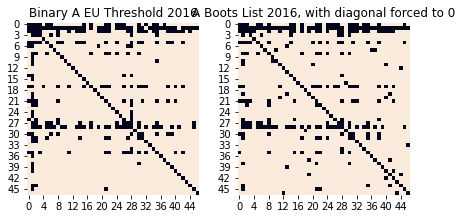

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

sns.heatmap(binary_A_eu_thres[0], ax=axs[0], square=True, cbar=False)
axs[0].set_title('Binary A EU Threshold 2016')

sns.heatmap(A_boots_list[0], ax=axs[1], square=True, cbar=False)
axs[1].set_title('A Boots List 2016, with diagonal forced to 0')

plt.tight_layout()
plt.show()

In [40]:
# for m in range(10):
#     matrixlist = binary_A_eu_thres[1::] # 2017-2021
#     matrixlist.append(A_boots_list[m]) # mth bootstrap of 2016 matrix 
#     ya = UASE(matrixlist, d, flat=False)

#     p_val_matrix = np.ones((T, T))
#     num_p_val_comps = 0
#     num_p_vals_to_compute = int(T * (T - 1) / 2)
#     # nodes_compared_mat = np.zeros((T, T))
#     for i in tqdm(range(p_val_matrix.shape[0])):
#         for j in range(p_val_matrix.shape[1]):
#             num_p_val_comps += 1

#             p_val = vector_displacement_test(ya[i], ya[j]) # #this is not a test, this is a distance, which one could call a "test statistic"
#             p_val_matrix[i, j] = p_val

#     p_val_mat = plt.matshow(p_val_matrix)
#     plt.colorbar(p_val_mat)


In [68]:
# for each matrix create one bootstrap
# compare the real series vs the boostrapped series
random.seed(21)
p_vals = []
A_boots_list = []

for m in range(T):
    p_val, A_boots = create_single_kNN_bootstrap_force0diag(binary_A_eu_thres[m], d=d, Q=1000, n_neighbors=3)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

unfold_both_series = np.concatenate((binary_A_eu_thres, A_boots_list))
ya = UASE(unfold_both_series, d, flat=True)
p_val = test_temporal_displacement_two_times(ya, n=ya[0].shape[0]/2 , n_sim=1000)
p_val

# want above 5% to happen 95% of the time for uniformity

0.266

In [71]:
manypvals = []
for i in range(100):
    random.seed(21)
    p_vals = []
    A_boots_list = []

    for m in range(T):
        p_val, A_boots = create_single_kNN_bootstrap_force0diag(binary_A_eu_thres[m], d=d, Q=1000, n_neighbors=3)
        p_vals.append(p_val)
        A_boots_list.append(A_boots)

    unfold_both_series = np.concatenate((binary_A_eu_thres, A_boots_list))
    ya = UASE(unfold_both_series, d, flat=True)
    p_val = test_temporal_displacement_two_times(ya, n=ya[0].shape[0]/2 , n_sim=1000)
    manypvals.append(p_val)

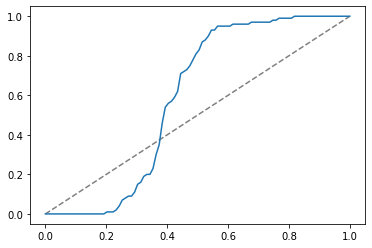

0.0

In [72]:
plot_power(manypvals, plot=True)

(array([ 1.,  7.,  2.,  8.,  3., 19., 16., 10.,  8.,  8.,  8.,  4.,  1.,
         1.,  0.,  1.,  0.,  1.,  1.,  1.]),
 array([0.195 , 0.2257, 0.2564, 0.2871, 0.3178, 0.3485, 0.3792, 0.4099,
        0.4406, 0.4713, 0.502 , 0.5327, 0.5634, 0.5941, 0.6248, 0.6555,
        0.6862, 0.7169, 0.7476, 0.7783, 0.809 ]),
 <BarContainer object of 20 artists>)

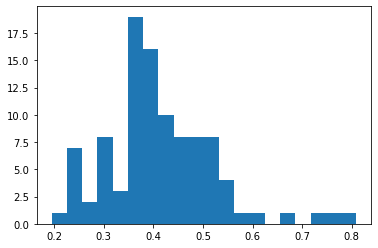

In [73]:
plt.hist(manypvals, bins=20)